In [9]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
import cv2

In [3]:

print(tf.config.list_physical_devices('GPU'))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
Num GPUs Available:  2


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [4]:
# Set the path to your dataset
#base_dir = '../output/approach-2/'
#base_dir = '../output/0_1/'
#base_dir = '../output/0_2/'
#base_dir = '../output/1_2/'
base_dirs = ['../output/0_1/', '../output/0_2/', '../output/1_2/']

In [45]:
# Create a generator for reading images from the dataset
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
data = {}

In [46]:
# Flow images from the dataset, splitting them into training and validation sets
for bd in base_dirs:
    train_generator = datagen.flow_from_directory(
        bd,  
        target_size=(224, 224),  
        batch_size=32,
        class_mode='categorical',  
        color_mode='grayscale',  
        subset='training'  
    )

    val_generator = datagen.flow_from_directory(
        bd,  
        target_size=(224, 224),  
        batch_size=32,
        class_mode='categorical',  
        color_mode='grayscale',  
        subset='validation'  
    )
    key = bd.split('/')[-2]
    data[key] = (train_generator, val_generator)

Found 2288 images belonging to 2 classes.
Found 571 images belonging to 2 classes.
Found 2576 images belonging to 2 classes.
Found 643 images belonging to 2 classes.
Found 2670 images belonging to 2 classes.
Found 666 images belonging to 2 classes.


In [35]:
list(data.keys())

['0_1', '0_2', '1_2']

In [7]:
from tensorflow.keras import regularizers

In [47]:
def create_model():
    # Create a CNN model
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1), kernel_regularizer=regularizers.l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(MaxPooling2D((2, 2)))
    #model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    #model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    #model.add(Dropout(0.5))
    #model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dense(2, activation='softmax'))  # 3 classes (0, 1, 2)
    return model

In [43]:
model = create_model()
#model.summary()

In [7]:
from keras.utils import plot_model, model_to_dot

# Assuming 'model' is your neural network model
# plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
# Assuming 'model' is your neural network model
dot = model_to_dot(model, show_shapes=True, show_layer_names=True)

# Save the DOT file
with open("sequential_model.dot", "w") as dot_file:
    dot_file.write(dot.to_string())

In [12]:
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad, Adadelta, Adamax, Nadam

In [13]:
# Compile the model
model.compile(optimizer=Adagrad(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [48]:
# Best hyperparameters: {'learning_rate': 0.001, 'num_filters': 32, 'num_layers': 2, 'batch_size': 32, 'epochs': 20, 'optimizer': 'adagrad', 
# 'batch_norm': True, 'drop_out': 0.2}
histories = {}
for k,v in data.items():
    # Train the model
    print('comparing ', k)
    train_generator = v[0]
    val_generator = v[1]
    model = create_model()
    model.compile(optimizer=Adagrad(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.n // train_generator.batch_size,
        epochs=20,
        validation_data=val_generator,
        validation_steps=val_generator.n // val_generator.batch_size  
    )
    histories[k] = (model,history)

comparing  0_1
Epoch 1/20
71/71 [==============================] - 7s 94ms/step - loss: 0.8284 - accuracy: 0.6613 - val_loss: 0.9198 - val_accuracy: 0.5202
Epoch 2/20
71/71 [==============================] - 6s 88ms/step - loss: 0.5905 - accuracy: 0.7407 - val_loss: 1.3383 - val_accuracy: 0.5184
Epoch 3/20
71/71 [==============================] - 7s 92ms/step - loss: 0.5125 - accuracy: 0.8023 - val_loss: 1.5436 - val_accuracy: 0.5221
Epoch 4/20
71/71 [==============================] - 6s 89ms/step - loss: 0.4590 - accuracy: 0.8364 - val_loss: 2.2783 - val_accuracy: 0.5202
Epoch 5/20
71/71 [==============================] - 7s 93ms/step - loss: 0.4063 - accuracy: 0.8679 - val_loss: 1.7537 - val_accuracy: 0.5147
Epoch 6/20
71/71 [==============================] - 6s 91ms/step - loss: 0.3664 - accuracy: 0.8892 - val_loss: 1.6090 - val_accuracy: 0.3971
Epoch 7/20
71/71 [==============================] - 7s 95ms/step - loss: 0.3312 - accuracy: 0.9074 - val_loss: 1.6705 - val_accuracy: 0.384

In [40]:
history

In [49]:
def showDetails(history, k):
    c = k.split('_')
    plt.figure(figsize=(8, 6))
    #plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.ylim([0,1.2])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title(f'Class {c[0]} and Class {c[1]}')

    plt.figure(figsize=(8, 6))
    #plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    #plt.ylim([0.0,1])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Class {c[0]} and Class {c[1]}')

    plt.show()

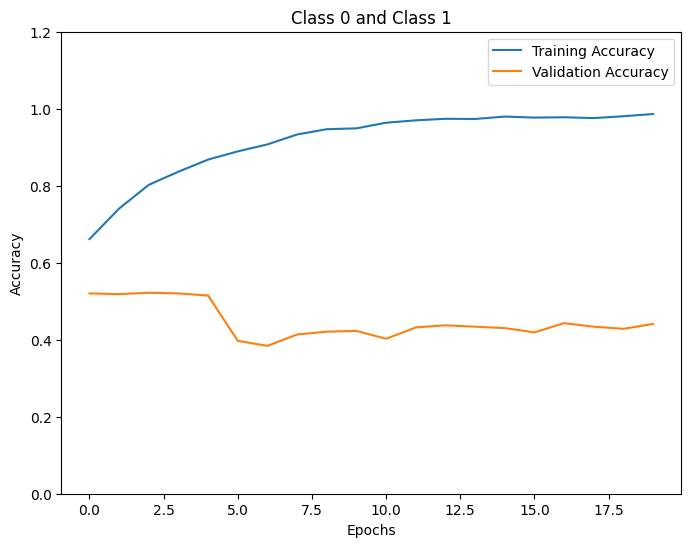

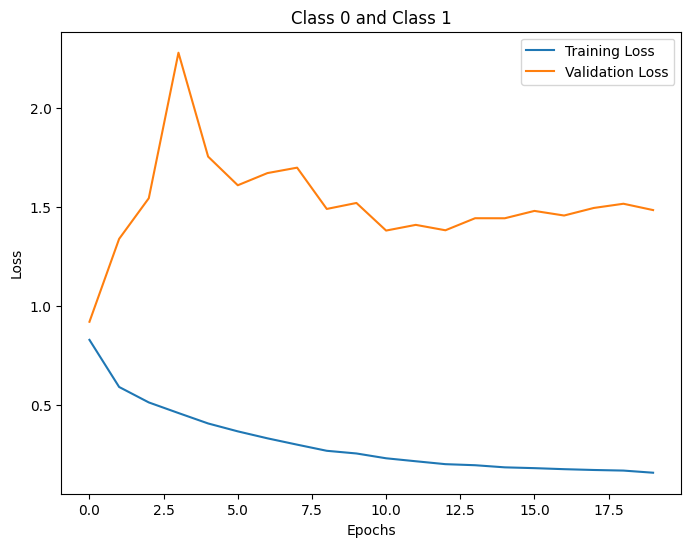

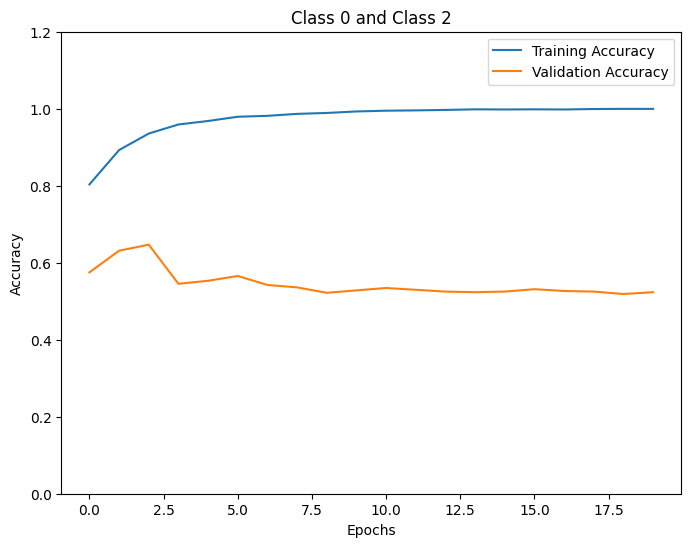

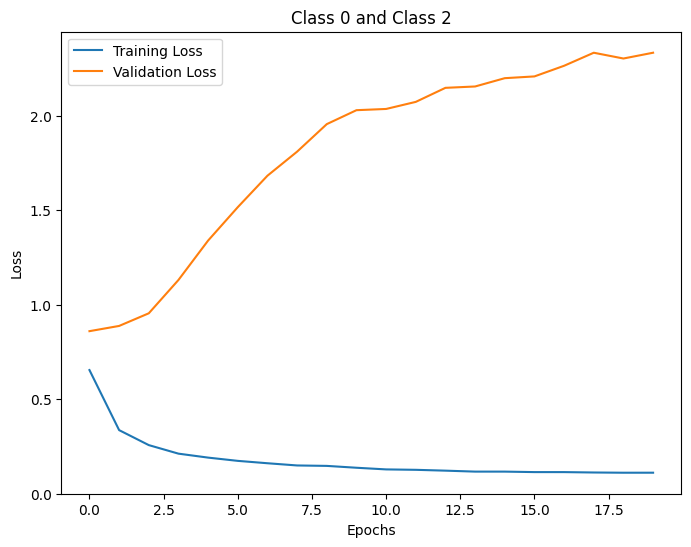

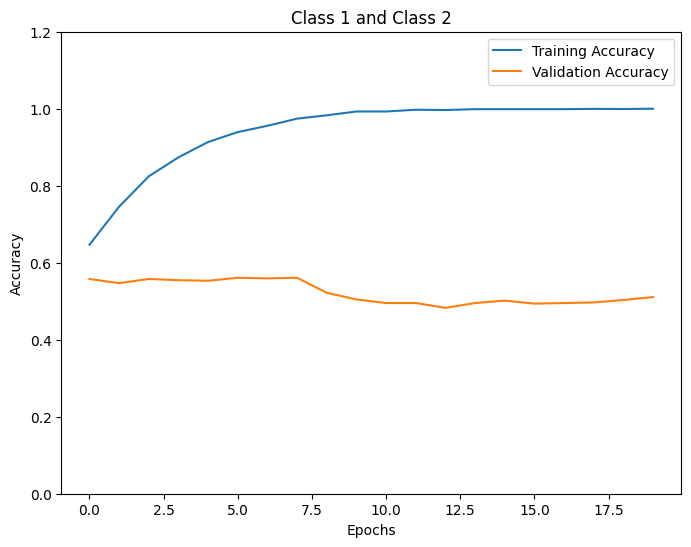

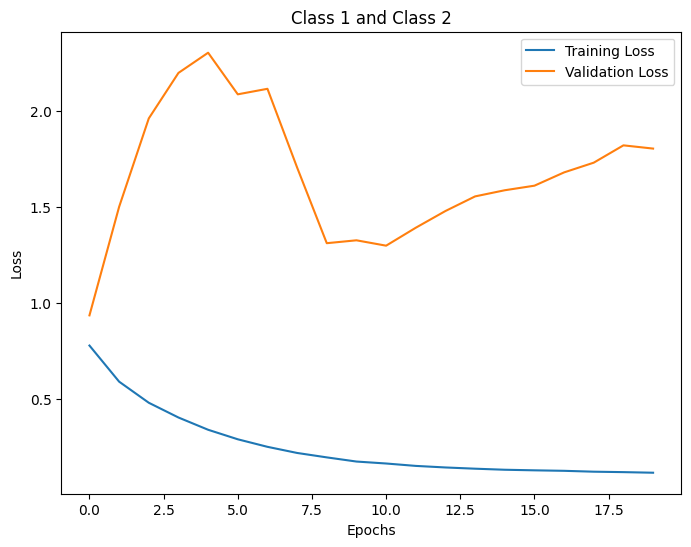

In [50]:
for k,v in histories.items():
    showDetails(v[1], k)

In [51]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

0_1
18/18 [==============================] - 2s 69ms/step


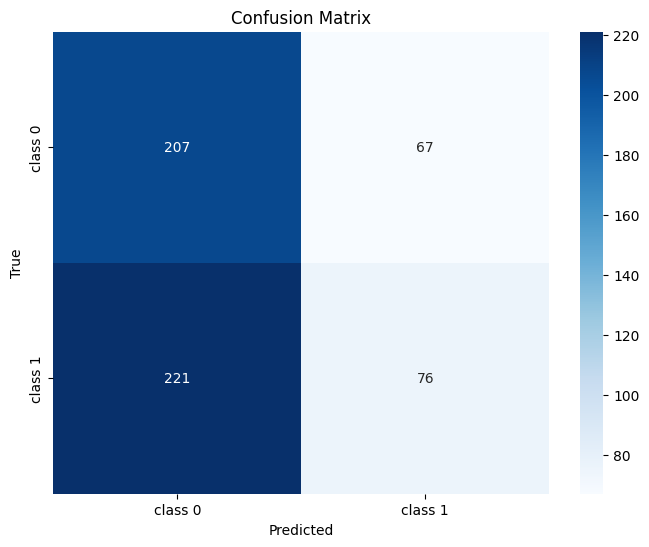

              precision    recall  f1-score   support

     class 0       0.48      0.76      0.59       274
     class 1       0.53      0.26      0.35       297

    accuracy                           0.50       571
   macro avg       0.51      0.51      0.47       571
weighted avg       0.51      0.50      0.46       571

0_2
21/21 [==============================] - 2s 78ms/step


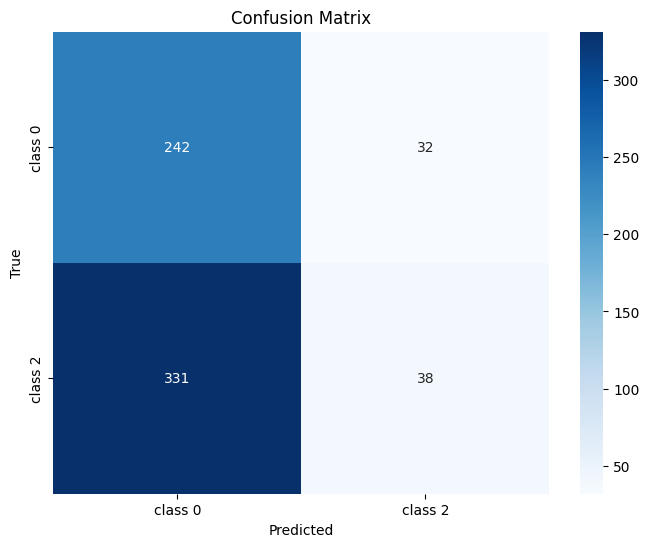

              precision    recall  f1-score   support

     class 0       0.42      0.88      0.57       274
     class 2       0.54      0.10      0.17       369

    accuracy                           0.44       643
   macro avg       0.48      0.49      0.37       643
weighted avg       0.49      0.44      0.34       643

1_2
21/21 [==============================] - 2s 78ms/step


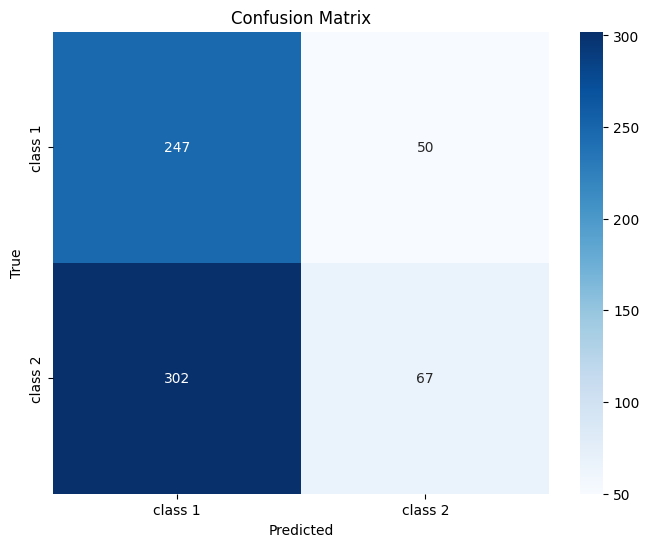

              precision    recall  f1-score   support

     class 1       0.45      0.83      0.58       297
     class 2       0.57      0.18      0.28       369

    accuracy                           0.47       666
   macro avg       0.51      0.51      0.43       666
weighted avg       0.52      0.47      0.41       666



In [52]:

for k, v in data.items():
    c = k.split('_')
    labels = {0: f'class {c[0]}', 1: f'class {c[1]}'}
    # Get predictions
    print(k)
    model = histories[k][0]
    val_generator = v[1]
    Y_pred = model.predict(val_generator)
    y_pred = np.argmax(Y_pred, axis=1)

    y_true = val_generator.classes

    # Plot confusion matrix with numerical values
    conf_mat = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=labels.values(), yticklabels=labels.values())
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Print classification report
    print(classification_report(y_true, y_pred, target_names=labels.values()))

In [ ]:
# Get predictions
Y_pred = model.predict(val_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Convert labels back to original encoding
# labels = {0: 'Low', 1: 'Average', 2: 'High'}
labels = {0: 'Low', 1: 'High'}
validation_labels = [labels[k] for k in val_generator.classes]
y_true = val_generator.classes

# Plot confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
plt.imshow(conf_mat, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(np.arange(len(labels)), labels.values(), rotation=45)
plt.yticks(np.arange(len(labels)), labels.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [58]:
# Get predictions
Y_pred = model.predict(val_generator)
y_pred = np.argmax(Y_pred, axis=1)

20/20 [==============================] - 2s 76ms/step


In [ ]:
# Convert labels back to original encoding
# labels = {0: 'Low', 1: 'Average', 2: 'High'}
labels = {0: 'Low', 1: 'High'}
#validation_labels = [labels[k] for k in val_generator.classes]
validation_labels = val_generator.classes
#print(y_pred)
y_true = val_generator.classes
#print(y_true)

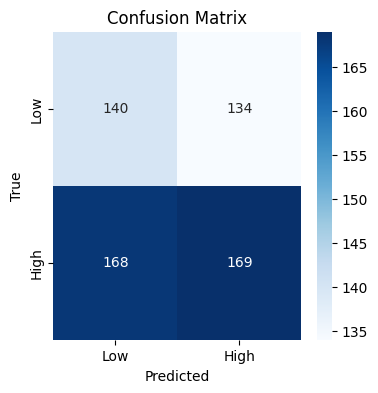

              precision    recall  f1-score   support

         Low       0.45      0.51      0.48       274
        High       0.56      0.50      0.53       337

    accuracy                           0.51       611
   macro avg       0.51      0.51      0.50       611
weighted avg       0.51      0.51      0.51       611



In [64]:


# Plot confusion matrix with numerical values
conf_mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=labels.values(), yticklabels=labels.values())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred, target_names=labels.values()))

20/20 [==============================] - 2s 82ms/step


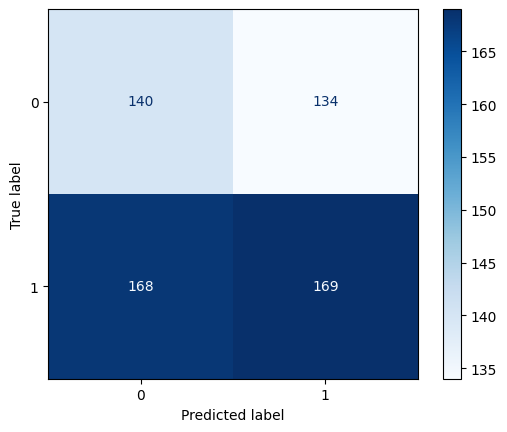

In [60]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming y_true and y_pred are your true and predicted labels
# Get true labels
y_true = val_generator.classes

# Get predicted probabilities
Y_pred = model.predict(val_generator)

# Get predicted class indices
y_pred = np.argmax(Y_pred, axis=1)

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_generator.class_indices.keys())
disp.plot(cmap='Blues', values_format='d')
plt.show()

In [34]:
base_dir = '../output/approach-2/'

In [35]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [23]:
train_generator = datagen.flow_from_directory(
    base_dir,  
    target_size=(224, 224),  
    batch_size=64,
    class_mode='categorical',  
    color_mode='grayscale',  
    subset='training'  
)

val_generator = datagen.flow_from_directory(
    base_dir,  
    target_size=(224, 224),  
    batch_size=64,
    class_mode='categorical',  
    color_mode='grayscale',  
    subset='validation'  
)

Found 3756 images belonging to 3 classes.
Found 937 images belonging to 3 classes.


In [24]:
#{'learning_rate': 0.001, 'num_filters': 16, 'num_layers': 2, 'batch_size': 16, 'epochs': 20, 'optimizer': 'adagrad'}
def create_model_3():
    # Create a CNN model
    model = Sequential()
    model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 1))) #, kernel_regularizer=regularizers.l2(0.001)
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(16, (3, 3), activation='relu')) # , kernel_regularizer=regularizers.l2(0.001)
    model.add(MaxPooling2D((2, 2)))
    #model.add(Conv2D(64, (3, 3), activation='relu'))
    #model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    #model.add(Dropout(0.5))
    #model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dense(3, activation='softmax'))  # 3 classes (0, 1, 2)
    return model

## Manual model Optuna

In [25]:
import optuna

In [39]:
def create_optuna_model(num_filters, num_layers,batch_norm, drop_out=0):
    model = Sequential()
    for _ in range(num_layers):
        model.add(Conv2D(num_filters, (3, 3), activation='relu', input_shape=(224, 224, 1))) #, kernel_regularizer=regularizers.l2(0.001)
        if batch_norm:
            model.add(BatchNormalization())
        if drop_out > 0:
            model.add(Dropout(drop_out))
        model.add(MaxPooling2D((2, 2)))
    
    model.add(Flatten())
    model.add(Dense(num_filters, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    #model.add(Dropout(0.5))
    #model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dense(3, activation='softmax'))  # 3 classes (0, 1, 2)
    return model

In [28]:
def get_optimizer(name, learning_rate):
    if name == 'adam':
        return Adam(learning_rate=learning_rate)
    elif name == 'sgd':
        return SGD(learning_rate=learning_rate)
    elif name == 'rmsprop':
        return RMSprop(learning_rate=learning_rate)
    elif name == 'adagrad':
        return Adagrad(learning_rate=learning_rate)
    elif name == 'adadelta':
        return Adadelta(learning_rate=learning_rate)
    elif name == 'adamax':
        return Adamax(learning_rate=learning_rate)
    elif name == 'nadam':
        return Nadam(learning_rate=learning_rate)
    else:
        raise ValueError(f"Unknown optimizer: {name}")

In [40]:
def objective(trial):

    learning_rate = trial.suggest_categorical('learning_rate', [0.001, 0.01, 0.1])
    num_filters = trial.suggest_categorical('num_filters', [16, 32])
    num_layers = trial.suggest_int('num_layers', 1, 2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    epochs = trial.suggest_categorical('epochs', [10, 15, 20])
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'sgd', 'rmsprop', 'adagrad', 'adadelta', 'adamax', 'nadam'])
    batch_norm = trial.suggest_categorical('batch_norm', [True, False])
    drop_out = trial.suggest_categorical('drop_out', [0.1, 0.2, 0.3])


    model = create_optuna_model(num_filters, num_layers, batch_norm, drop_out=drop_out)

    optimizer = get_optimizer(optimizer_name, learning_rate)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    # Split the data into training and validation sets
    train_generator = datagen.flow_from_directory(
        base_dir,  
        target_size=(224, 224),  
        batch_size=batch_size,
        class_mode='categorical',  
        color_mode='grayscale',  
        subset='training'  
    )

    val_generator = datagen.flow_from_directory(
        base_dir,  
        target_size=(224, 224),  
        batch_size=batch_size,
        class_mode='categorical',  
        color_mode='grayscale',  
        subset='validation'  
    )

    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.n // train_generator.batch_size,
        epochs=epochs,
        validation_data=val_generator,
        validation_steps=val_generator.n // val_generator.batch_size,
        verbose=0
    )

    # Return the validation accuracy for Optuna to optimize
    return history.history['val_accuracy'][-1]

In [41]:
# with more hyper parameter
# Create a study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=40)

# Print the best parameters found by Optuna
print('Best trial:')
trial = study.best_trial
print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2024-01-18 21:22:53,230] A new study created in memory with name: no-name-e68b12dc-3d1f-4c7e-8f3d-4a3dc77ef555


Found 3756 images belonging to 3 classes.
Found 937 images belonging to 3 classes.


[I 2024-01-18 21:27:03,503] Trial 0 finished with value: 0.3976293206214905 and parameters: {'learning_rate': 0.1, 'num_filters': 16, 'num_layers': 1, 'batch_size': 16, 'epochs': 20, 'optimizer': 'rmsprop', 'batch_norm': False, 'drop_out': 0.1}. Best is trial 0 with value: 0.3976293206214905.


Found 3756 images belonging to 3 classes.
Found 937 images belonging to 3 classes.


[I 2024-01-18 21:30:08,732] Trial 1 finished with value: 0.39116379618644714 and parameters: {'learning_rate': 0.01, 'num_filters': 16, 'num_layers': 1, 'batch_size': 16, 'epochs': 15, 'optimizer': 'adagrad', 'batch_norm': False, 'drop_out': 0.2}. Best is trial 0 with value: 0.3976293206214905.


Found 3756 images belonging to 3 classes.
Found 937 images belonging to 3 classes.


[I 2024-01-18 21:31:54,291] Trial 2 finished with value: 0.4170258641242981 and parameters: {'learning_rate': 0.1, 'num_filters': 32, 'num_layers': 1, 'batch_size': 32, 'epochs': 10, 'optimizer': 'adadelta', 'batch_norm': True, 'drop_out': 0.1}. Best is trial 2 with value: 0.4170258641242981.


Found 3756 images belonging to 3 classes.
Found 937 images belonging to 3 classes.


[I 2024-01-18 21:34:31,512] Trial 3 finished with value: 0.3857758641242981 and parameters: {'learning_rate': 0.01, 'num_filters': 32, 'num_layers': 1, 'batch_size': 32, 'epochs': 15, 'optimizer': 'adagrad', 'batch_norm': True, 'drop_out': 0.2}. Best is trial 2 with value: 0.4170258641242981.


Found 3756 images belonging to 3 classes.
Found 937 images belonging to 3 classes.


[I 2024-01-18 21:38:03,083] Trial 4 finished with value: 0.4612068831920624 and parameters: {'learning_rate': 0.01, 'num_filters': 32, 'num_layers': 2, 'batch_size': 32, 'epochs': 20, 'optimizer': 'adamax', 'batch_norm': False, 'drop_out': 0.1}. Best is trial 4 with value: 0.4612068831920624.


Found 3756 images belonging to 3 classes.
Found 937 images belonging to 3 classes.


[I 2024-01-18 21:42:25,401] Trial 5 finished with value: 0.4030172526836395 and parameters: {'learning_rate': 0.1, 'num_filters': 16, 'num_layers': 2, 'batch_size': 16, 'epochs': 20, 'optimizer': 'adamax', 'batch_norm': True, 'drop_out': 0.2}. Best is trial 4 with value: 0.4612068831920624.


Found 3756 images belonging to 3 classes.
Found 937 images belonging to 3 classes.


[I 2024-01-18 21:44:04,119] Trial 6 finished with value: 0.3973214328289032 and parameters: {'learning_rate': 0.01, 'num_filters': 16, 'num_layers': 2, 'batch_size': 64, 'epochs': 10, 'optimizer': 'adadelta', 'batch_norm': True, 'drop_out': 0.3}. Best is trial 4 with value: 0.4612068831920624.


Found 3756 images belonging to 3 classes.
Found 937 images belonging to 3 classes.


[I 2024-01-18 21:46:22,303] Trial 7 finished with value: 0.3943965435028076 and parameters: {'learning_rate': 0.1, 'num_filters': 32, 'num_layers': 1, 'batch_size': 16, 'epochs': 10, 'optimizer': 'rmsprop', 'batch_norm': False, 'drop_out': 0.2}. Best is trial 4 with value: 0.4612068831920624.


Found 3756 images belonging to 3 classes.
Found 937 images belonging to 3 classes.


[I 2024-01-18 21:48:17,114] Trial 8 finished with value: 0.4590517282485962 and parameters: {'learning_rate': 0.001, 'num_filters': 32, 'num_layers': 1, 'batch_size': 32, 'epochs': 10, 'optimizer': 'rmsprop', 'batch_norm': False, 'drop_out': 0.2}. Best is trial 4 with value: 0.4612068831920624.


Found 3756 images belonging to 3 classes.
Found 937 images belonging to 3 classes.


[I 2024-01-18 21:52:43,305] Trial 9 finished with value: 0.36853447556495667 and parameters: {'learning_rate': 0.1, 'num_filters': 32, 'num_layers': 1, 'batch_size': 16, 'epochs': 20, 'optimizer': 'sgd', 'batch_norm': True, 'drop_out': 0.3}. Best is trial 4 with value: 0.4612068831920624.


Found 3756 images belonging to 3 classes.
Found 937 images belonging to 3 classes.


[I 2024-01-18 21:55:57,308] Trial 10 finished with value: 0.4508928656578064 and parameters: {'learning_rate': 0.001, 'num_filters': 32, 'num_layers': 2, 'batch_size': 64, 'epochs': 20, 'optimizer': 'adamax', 'batch_norm': False, 'drop_out': 0.1}. Best is trial 4 with value: 0.4612068831920624.


Found 3756 images belonging to 3 classes.
Found 937 images belonging to 3 classes.


[I 2024-01-18 21:57:44,559] Trial 11 finished with value: 0.4612068831920624 and parameters: {'learning_rate': 0.001, 'num_filters': 32, 'num_layers': 2, 'batch_size': 32, 'epochs': 10, 'optimizer': 'adam', 'batch_norm': False, 'drop_out': 0.1}. Best is trial 4 with value: 0.4612068831920624.


Found 3756 images belonging to 3 classes.
Found 937 images belonging to 3 classes.


[I 2024-01-18 21:59:31,481] Trial 12 finished with value: 0.4612068831920624 and parameters: {'learning_rate': 0.001, 'num_filters': 32, 'num_layers': 2, 'batch_size': 32, 'epochs': 10, 'optimizer': 'adam', 'batch_norm': False, 'drop_out': 0.1}. Best is trial 4 with value: 0.4612068831920624.


Found 3756 images belonging to 3 classes.
Found 937 images belonging to 3 classes.


[I 2024-01-18 22:03:09,446] Trial 13 finished with value: 0.4881465435028076 and parameters: {'learning_rate': 0.001, 'num_filters': 32, 'num_layers': 2, 'batch_size': 32, 'epochs': 20, 'optimizer': 'nadam', 'batch_norm': False, 'drop_out': 0.1}. Best is trial 13 with value: 0.4881465435028076.


Found 3756 images belonging to 3 classes.
Found 937 images belonging to 3 classes.


[I 2024-01-18 22:06:46,755] Trial 14 finished with value: 0.4590517282485962 and parameters: {'learning_rate': 0.01, 'num_filters': 32, 'num_layers': 2, 'batch_size': 32, 'epochs': 20, 'optimizer': 'nadam', 'batch_norm': False, 'drop_out': 0.1}. Best is trial 13 with value: 0.4881465435028076.


Found 3756 images belonging to 3 classes.
Found 937 images belonging to 3 classes.


[I 2024-01-18 22:10:21,372] Trial 15 finished with value: 0.4493534564971924 and parameters: {'learning_rate': 0.001, 'num_filters': 32, 'num_layers': 2, 'batch_size': 32, 'epochs': 20, 'optimizer': 'nadam', 'batch_norm': False, 'drop_out': 0.1}. Best is trial 13 with value: 0.4881465435028076.


Found 3756 images belonging to 3 classes.
Found 937 images belonging to 3 classes.


[I 2024-01-18 22:13:57,069] Trial 16 finished with value: 0.4471982717514038 and parameters: {'learning_rate': 0.01, 'num_filters': 32, 'num_layers': 2, 'batch_size': 32, 'epochs': 20, 'optimizer': 'adamax', 'batch_norm': False, 'drop_out': 0.1}. Best is trial 13 with value: 0.4881465435028076.


Found 3756 images belonging to 3 classes.
Found 937 images belonging to 3 classes.


[I 2024-01-18 22:17:06,202] Trial 17 finished with value: 0.4832589328289032 and parameters: {'learning_rate': 0.001, 'num_filters': 32, 'num_layers': 2, 'batch_size': 64, 'epochs': 20, 'optimizer': 'nadam', 'batch_norm': False, 'drop_out': 0.3}. Best is trial 13 with value: 0.4881465435028076.


Found 3756 images belonging to 3 classes.
Found 937 images belonging to 3 classes.


[I 2024-01-18 22:19:28,082] Trial 18 finished with value: 0.4888392984867096 and parameters: {'learning_rate': 0.001, 'num_filters': 16, 'num_layers': 2, 'batch_size': 64, 'epochs': 15, 'optimizer': 'nadam', 'batch_norm': False, 'drop_out': 0.3}. Best is trial 18 with value: 0.4888392984867096.


Found 3756 images belonging to 3 classes.
Found 937 images belonging to 3 classes.


[I 2024-01-18 22:21:50,198] Trial 19 finished with value: 0.4352678656578064 and parameters: {'learning_rate': 0.001, 'num_filters': 16, 'num_layers': 2, 'batch_size': 64, 'epochs': 15, 'optimizer': 'nadam', 'batch_norm': False, 'drop_out': 0.3}. Best is trial 18 with value: 0.4888392984867096.


Found 3756 images belonging to 3 classes.
Found 937 images belonging to 3 classes.


[I 2024-01-18 22:24:15,366] Trial 20 finished with value: 0.4854910671710968 and parameters: {'learning_rate': 0.001, 'num_filters': 16, 'num_layers': 2, 'batch_size': 64, 'epochs': 15, 'optimizer': 'nadam', 'batch_norm': False, 'drop_out': 0.3}. Best is trial 18 with value: 0.4888392984867096.


Found 3756 images belonging to 3 classes.
Found 937 images belonging to 3 classes.


[I 2024-01-18 22:26:39,804] Trial 21 finished with value: 0.4308035671710968 and parameters: {'learning_rate': 0.001, 'num_filters': 16, 'num_layers': 2, 'batch_size': 64, 'epochs': 15, 'optimizer': 'nadam', 'batch_norm': False, 'drop_out': 0.3}. Best is trial 18 with value: 0.4888392984867096.


Found 3756 images belonging to 3 classes.
Found 937 images belonging to 3 classes.


[I 2024-01-18 22:29:04,117] Trial 22 finished with value: 0.4799107015132904 and parameters: {'learning_rate': 0.001, 'num_filters': 16, 'num_layers': 2, 'batch_size': 64, 'epochs': 15, 'optimizer': 'nadam', 'batch_norm': False, 'drop_out': 0.3}. Best is trial 18 with value: 0.4888392984867096.


Found 3756 images belonging to 3 classes.
Found 937 images belonging to 3 classes.


[I 2024-01-18 22:31:27,390] Trial 23 finished with value: 0.4654017984867096 and parameters: {'learning_rate': 0.001, 'num_filters': 16, 'num_layers': 2, 'batch_size': 64, 'epochs': 15, 'optimizer': 'nadam', 'batch_norm': False, 'drop_out': 0.3}. Best is trial 18 with value: 0.4888392984867096.


Found 3756 images belonging to 3 classes.
Found 937 images belonging to 3 classes.


[I 2024-01-18 22:33:51,481] Trial 24 finished with value: 0.4709821343421936 and parameters: {'learning_rate': 0.001, 'num_filters': 16, 'num_layers': 2, 'batch_size': 64, 'epochs': 15, 'optimizer': 'sgd', 'batch_norm': False, 'drop_out': 0.3}. Best is trial 18 with value: 0.4888392984867096.


Found 3756 images belonging to 3 classes.
Found 937 images belonging to 3 classes.


[I 2024-01-18 22:36:14,705] Trial 25 finished with value: 0.4508928656578064 and parameters: {'learning_rate': 0.001, 'num_filters': 16, 'num_layers': 2, 'batch_size': 64, 'epochs': 15, 'optimizer': 'nadam', 'batch_norm': False, 'drop_out': 0.3}. Best is trial 18 with value: 0.4888392984867096.


Found 3756 images belonging to 3 classes.
Found 937 images belonging to 3 classes.


[I 2024-01-18 22:38:36,561] Trial 26 finished with value: 0.3850446343421936 and parameters: {'learning_rate': 0.001, 'num_filters': 16, 'num_layers': 2, 'batch_size': 64, 'epochs': 15, 'optimizer': 'nadam', 'batch_norm': True, 'drop_out': 0.3}. Best is trial 18 with value: 0.4888392984867096.


Found 3756 images belonging to 3 classes.
Found 937 images belonging to 3 classes.


[I 2024-01-18 22:40:58,416] Trial 27 finished with value: 0.4185267984867096 and parameters: {'learning_rate': 0.001, 'num_filters': 16, 'num_layers': 2, 'batch_size': 64, 'epochs': 15, 'optimizer': 'nadam', 'batch_norm': False, 'drop_out': 0.3}. Best is trial 18 with value: 0.4888392984867096.


Found 3756 images belonging to 3 classes.
Found 937 images belonging to 3 classes.


[I 2024-01-18 22:43:20,398] Trial 28 finished with value: 0.4508928656578064 and parameters: {'learning_rate': 0.001, 'num_filters': 16, 'num_layers': 2, 'batch_size': 64, 'epochs': 15, 'optimizer': 'nadam', 'batch_norm': False, 'drop_out': 0.3}. Best is trial 18 with value: 0.4888392984867096.


Found 3756 images belonging to 3 classes.
Found 937 images belonging to 3 classes.


[I 2024-01-18 22:45:42,467] Trial 29 finished with value: 0.46875 and parameters: {'learning_rate': 0.001, 'num_filters': 16, 'num_layers': 2, 'batch_size': 64, 'epochs': 15, 'optimizer': 'sgd', 'batch_norm': False, 'drop_out': 0.3}. Best is trial 18 with value: 0.4888392984867096.


Found 3756 images belonging to 3 classes.
Found 937 images belonging to 3 classes.


[I 2024-01-18 22:49:01,823] Trial 30 finished with value: 0.3943965435028076 and parameters: {'learning_rate': 0.001, 'num_filters': 16, 'num_layers': 1, 'batch_size': 16, 'epochs': 15, 'optimizer': 'adam', 'batch_norm': False, 'drop_out': 0.1}. Best is trial 18 with value: 0.4888392984867096.


Found 3756 images belonging to 3 classes.
Found 937 images belonging to 3 classes.


[I 2024-01-18 22:52:11,019] Trial 31 finished with value: 0.4542410671710968 and parameters: {'learning_rate': 0.001, 'num_filters': 32, 'num_layers': 2, 'batch_size': 64, 'epochs': 20, 'optimizer': 'nadam', 'batch_norm': False, 'drop_out': 0.3}. Best is trial 18 with value: 0.4888392984867096.


Found 3756 images belonging to 3 classes.
Found 937 images belonging to 3 classes.


[I 2024-01-18 22:55:17,967] Trial 32 finished with value: 0.4642857015132904 and parameters: {'learning_rate': 0.001, 'num_filters': 32, 'num_layers': 2, 'batch_size': 64, 'epochs': 20, 'optimizer': 'adagrad', 'batch_norm': False, 'drop_out': 0.3}. Best is trial 18 with value: 0.4888392984867096.


Found 3756 images belonging to 3 classes.
Found 937 images belonging to 3 classes.


[I 2024-01-18 22:58:27,726] Trial 33 finished with value: 0.4564732015132904 and parameters: {'learning_rate': 0.001, 'num_filters': 16, 'num_layers': 2, 'batch_size': 64, 'epochs': 20, 'optimizer': 'nadam', 'batch_norm': False, 'drop_out': 0.3}. Best is trial 18 with value: 0.4888392984867096.


Found 3756 images belonging to 3 classes.
Found 937 images belonging to 3 classes.


[I 2024-01-18 23:01:36,442] Trial 34 finished with value: 0.4430803656578064 and parameters: {'learning_rate': 0.1, 'num_filters': 32, 'num_layers': 2, 'batch_size': 64, 'epochs': 20, 'optimizer': 'adadelta', 'batch_norm': False, 'drop_out': 0.3}. Best is trial 18 with value: 0.4888392984867096.


Found 3756 images belonging to 3 classes.
Found 937 images belonging to 3 classes.


[I 2024-01-18 23:05:11,334] Trial 35 finished with value: 0.5290948152542114 and parameters: {'learning_rate': 0.001, 'num_filters': 32, 'num_layers': 2, 'batch_size': 32, 'epochs': 20, 'optimizer': 'adagrad', 'batch_norm': True, 'drop_out': 0.2}. Best is trial 35 with value: 0.5290948152542114.


Found 3756 images belonging to 3 classes.
Found 937 images belonging to 3 classes.


[I 2024-01-18 23:08:45,380] Trial 36 finished with value: 0.3512931168079376 and parameters: {'learning_rate': 0.001, 'num_filters': 16, 'num_layers': 2, 'batch_size': 32, 'epochs': 20, 'optimizer': 'adagrad', 'batch_norm': True, 'drop_out': 0.2}. Best is trial 35 with value: 0.5290948152542114.


Found 3756 images belonging to 3 classes.
Found 937 images belonging to 3 classes.


[I 2024-01-18 23:11:25,191] Trial 37 finished with value: 0.23275862634181976 and parameters: {'learning_rate': 0.1, 'num_filters': 32, 'num_layers': 2, 'batch_size': 32, 'epochs': 15, 'optimizer': 'adagrad', 'batch_norm': True, 'drop_out': 0.2}. Best is trial 35 with value: 0.5290948152542114.


Found 3756 images belonging to 3 classes.
Found 937 images belonging to 3 classes.


[I 2024-01-18 23:14:56,655] Trial 38 finished with value: 0.3857758641242981 and parameters: {'learning_rate': 0.01, 'num_filters': 16, 'num_layers': 1, 'batch_size': 32, 'epochs': 20, 'optimizer': 'adagrad', 'batch_norm': True, 'drop_out': 0.2}. Best is trial 35 with value: 0.5290948152542114.


Found 3756 images belonging to 3 classes.
Found 937 images belonging to 3 classes.


[I 2024-01-18 23:17:36,835] Trial 39 finished with value: 0.4364224076271057 and parameters: {'learning_rate': 0.001, 'num_filters': 32, 'num_layers': 2, 'batch_size': 32, 'epochs': 15, 'optimizer': 'rmsprop', 'batch_norm': True, 'drop_out': 0.2}. Best is trial 35 with value: 0.5290948152542114.


Best trial:
Accuracy: 0.5290948152542114
Best hyperparameters: {'learning_rate': 0.001, 'num_filters': 32, 'num_layers': 2, 'batch_size': 32, 'epochs': 20, 'optimizer': 'adagrad', 'batch_norm': True, 'drop_out': 0.2}


In [53]:
from optuna.visualization import plot_optimization_history

plotly_config = {"staticPlot": True}

fig = plot_optimization_history(study)
fig.show(config=plotly_config)

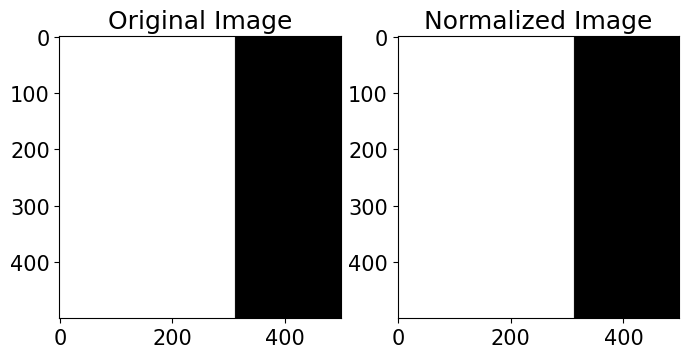

In [131]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Assuming you have the original and normalized images stored in original_image and normalized_image

# Load the original image
original_image_path = '../output/tiles/branch_line_coupler_0_250_0_5.png'
original_image = load_img(original_image_path, color_mode='grayscale', target_size=(500, 500))

# Convert the original image to an array
original_array = img_to_array(original_image)

# Normalize the pixel values
normalized_array = original_array / 255.0

# Display the original and normalized images side by side
plt.figure(figsize=(8, 4))

# # Original Image
# plt.subplot(1, 2, 1)
# plt.imshow(np.squeeze(original_array), cmap='gray')
# plt.title('Original Image')
# plt.axis('off')

# # Normalized Image
# plt.subplot(1, 2, 2)
# plt.imshow(np.squeeze(normalized_array), cmap='gray')
# plt.title('Normalized Image')
# plt.axis('off')

# plt.show()

# Plot the original image
plt.subplot(1, 2, 1)
plt.imshow(original_array.reshape(500, 500), cmap='gray')  # Assuming it's a grayscale image
plt.title('Original Image')

# Plot the normalized image
plt.subplot(1, 2, 2)
plt.imshow(normalized_array.reshape(500, 500), cmap='gray')  # Assuming it's a grayscale image
plt.title('Normalized Image')

plt.show()


In [133]:
normalized_array[50]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],

In [119]:
model_3 = create_model_3()
model_3.compile(optimizer=Adagrad(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
history = model_3.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=20,
    validation_data=val_generator,
    validation_steps=val_generator.n // val_generator.batch_size  
)

Epoch 1/20
58/58 [==============================] - 9s 146ms/step - loss: 1.1030 - accuracy: 0.4076 - val_loss: 1.1042 - val_accuracy: 0.3973
Epoch 2/20
58/58 [==============================] - 8s 141ms/step - loss: 1.0324 - accuracy: 0.5160 - val_loss: 1.0757 - val_accuracy: 0.4576
Epoch 3/20
58/58 [==============================] - 8s 139ms/step - loss: 0.9679 - accuracy: 0.5431 - val_loss: 1.0449 - val_accuracy: 0.4754
Epoch 4/20
58/58 [==============================] - 7s 124ms/step - loss: 0.8927 - accuracy: 0.5791 - val_loss: 1.0258 - val_accuracy: 0.4821
Epoch 5/20
58/58 [==============================] - 8s 140ms/step - loss: 0.8383 - accuracy: 0.6108 - val_loss: 1.0130 - val_accuracy: 0.4900
Epoch 6/20
58/58 [==============================] - 8s 137ms/step - loss: 0.7774 - accuracy: 0.6528 - val_loss: 1.0449 - val_accuracy: 0.5033
Epoch 7/20
58/58 [==============================] - 8s 143ms/step - loss: 0.7573 - accuracy: 0.6506 - val_loss: 1.0049 - val_accuracy: 0.4900
Epoch 

In [27]:
model.save('../output/model.h5')

In [112]:
plt.rcParams.update({'font.size': 15})
def showDetails_3(history, k):
    plt.figure(figsize=(8, 6))
    #plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.ylim([0,1.2])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    #plt.title(k)
    plt.show()

    plt.figure(figsize=(8,6))
    #plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.ylim([0.0,2])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    #plt.title(k)

    plt.show()

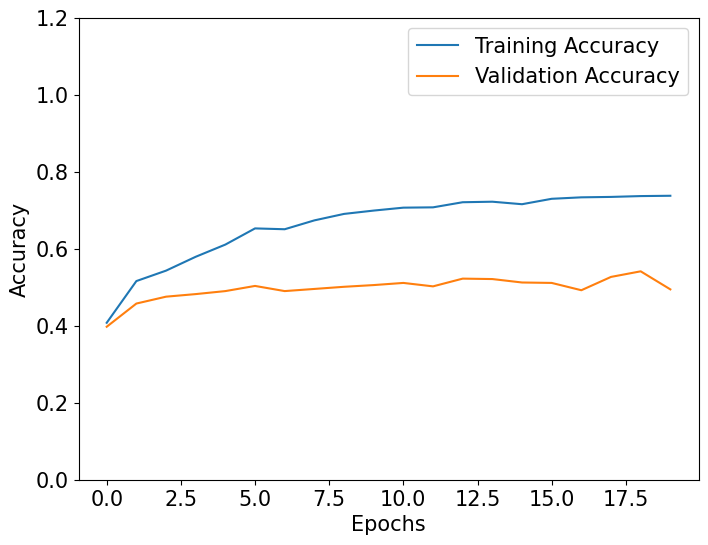

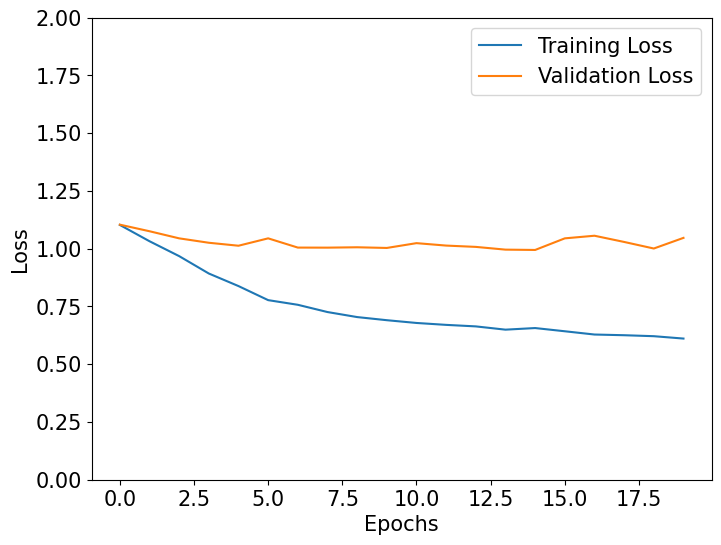

In [134]:
showDetails_3(history, 'Classification')

In [135]:
# Get predictions
Y_pred = model_3.predict(val_generator)
y_pred = np.argmax(Y_pred, axis=1)
labels = {0: 'Low', 1: 'Mid', 2: 'High'}
#labels = {0: 'Low', 1: 'High'}
#validation_labels = [labels[k] for k in val_generator.classes]
validation_labels = val_generator.classes
#print(y_pred)
y_true = val_generator.classes

15/15 [==============================] - 13s 902ms/step


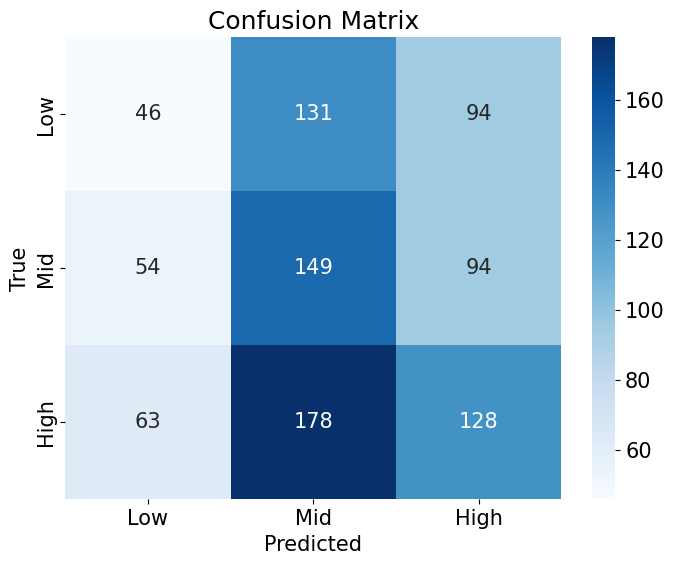

              precision    recall  f1-score   support

         Low       0.28      0.17      0.21       271
         Mid       0.33      0.50      0.39       297
        High       0.41      0.35      0.37       369

    accuracy                           0.34       937
   macro avg       0.34      0.34      0.33       937
weighted avg       0.34      0.34      0.33       937



In [136]:
# Plot confusion matrix with numerical values
conf_mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=labels.values(), yticklabels=labels.values())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred, target_names=labels.values()))

In [35]:
import os
from PIL import Image
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.regularizers import l2
import cv2

In [29]:
base_dir = '../output/approach-2/'

In [30]:
# Create an ImageDataGenerator with rescaling
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [31]:
def apply_sobel(image_array):
    sobel_image_array = cv2.Sobel(image_array, cv2.CV_64F, 1, 0, ksize=3)
    return np.expand_dims(sobel_image_array, axis=-1)

In [32]:
def custom_data_generator(directory, subset, batch_size):
    generator = datagen.flow_from_directory(
        directory,
        target_size=(64, 64),
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='grayscale',
        subset=subset
    )

    for data_batch, labels_batch in generator:
        sobel_data_batch = np.array([apply_sobel(image) for image in data_batch])
        yield sobel_data_batch, labels_batch

In [33]:
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(64, 64, 1), kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dense(3, activation='softmax'))  # Assuming 3 classes

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [36]:
history = model.fit(
    custom_data_generator(base_dir, 'training', batch_size=32),
    steps_per_epoch=100,  # Adjust as needed
    epochs=10,
    validation_data=custom_data_generator(base_dir, 'validation', batch_size=32),
    validation_steps=50  # Adjust as needed
)

Found 3756 images belonging to 3 classes.
Epoch 1/10
100/100 [==============================] - 51s 513ms/step - loss: 0.9733 - accuracy: 0.5628 - val_loss: 1.1364 - val_accuracy: 0.4344
Epoch 2/10
100/100 [==============================] - 14s 142ms/step - loss: 0.7863 - accuracy: 0.6764 - val_loss: 1.2682 - val_accuracy: 0.4395
Epoch 3/10
100/100 [==============================] - 9s 88ms/step - loss: 0.7003 - accuracy: 0.7220 - val_loss: 1.3501 - val_accuracy: 0.4961
Epoch 4/10
100/100 [==============================] - 9s 88ms/step - loss: 0.6240 - accuracy: 0.7563 - val_loss: 1.3843 - val_accuracy: 0.4933
Epoch 5/10
100/100 [==============================] - 9s 87ms/step - loss: 0.6003 - accuracy: 0.7789 - val_loss: 1.4143 - val_accuracy: 0.4903
Epoch 6/10
100/100 [==============================] - 8s 85ms/step - loss: 0.5762 - accuracy: 0.7991 - val_loss: 1.5106 - val_accuracy: 0.4595
Epoch 7/10
100/100 [==============================] - 9s 87ms/step - loss: 0.5038 - accuracy: 0.

In [52]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.utils import to_categorical

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [48]:
# Generate test data
test_generator = custom_data_generator(base_dir, 'validation', batch_size=32)
# Get the number of batches (steps) in the generator
test_steps = test_generator.n // test_generator.batch_size

# Account for the last batch if it's not a full batch
if test_generator.n % test_generator.batch_size != 0:
    test_steps += 1

# Get true labels
true_labels = []
for _ in range(test_steps):
    _, labels_batch = next(test_generator)
    true_labels.extend(np.argmax(labels_batch, axis=1))

NameError: name 'custom_data_generator' is not defined

In [49]:
predictions = model.predict_generator(test_generator, steps=test_steps, verbose=1)
predicted_labels = np.argmax(predictions, axis=1)

# Map classes to their names
class_names = {v: k for k, v in train_generator.class_indices.items()}

# Plot confusion matrix
plot_confusion_matrix(true_labels, predicted_labels, class_names.values())

# Evaluate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy * 100:.2f}%")

NameError: name 'test_generator' is not defined

In [50]:
# Get predictions
val_generator = custom_data_generator(base_dir, 'validation', batch_size=32)


NameError: name 'custom_data_generator' is not defined

In [ ]:
list(val_generator)

In [47]:
Y_pred = model.predict(val_generator)
y_pred = np.argmax(Y_pred, axis=1)
labels = {0: 'Low', 1: 'Average', 2: 'High'}
#labels = {0: 'Low', 1: 'High'}
#validation_labels = [labels[k] for k in val_generator.classes]
validation_labels = val_generator.classes
#print(y_pred)
y_true = val_generator.classes

Found 937 images belonging to 3 classes.
   8551/Unknown - 462s 54ms/step

KeyboardInterrupt: 

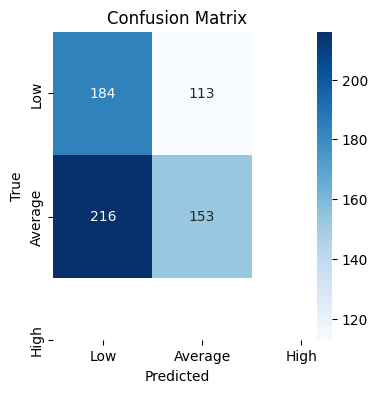

ValueError: Number of classes, 2, does not match size of target_names, 3. Try specifying the labels parameter

In [51]:
# Plot confusion matrix with numerical values
conf_mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=labels.values(), yticklabels=labels.values())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred, target_names=labels.values()))

In [49]:
import os
import cv2
import numpy as np

# Function to apply Sobel filter to an image
def apply_sobel(image):
    # Your Sobel filter implementation
    # For example:
    sobel_image = cv2.Sobel(image, cv2.CV_64F, 1, 1, ksize=3)
    return sobel_image

# Source and destination directories
source_directory = '../output/approach-2/'
destination_directory = '../output/sobel/'

# Iterate through the source directory
for category_folder in os.listdir(source_directory):
    category_path = os.path.join(source_directory, category_folder)
    
    # Ensure it's a directory
    if os.path.isdir(category_path):
        # Create a subdirectory in the destination folder
        destination_category_path = os.path.join(destination_directory, category_folder)
        os.makedirs(destination_category_path, exist_ok=True)
        
        # Process each image in the category folder
        for filename in os.listdir(category_path):
            if filename.endswith(('.jpg', '.png')):  # Adjust based on your image format
                # Read the image
                image_path = os.path.join(category_path, filename)
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                
                # Apply Sobel filter
                sobel_image = apply_sobel(image)
                
                # Save the processed image to the destination folder
                destination_path = os.path.join(destination_category_path, filename)
                cv2.imwrite(destination_path, sobel_image)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


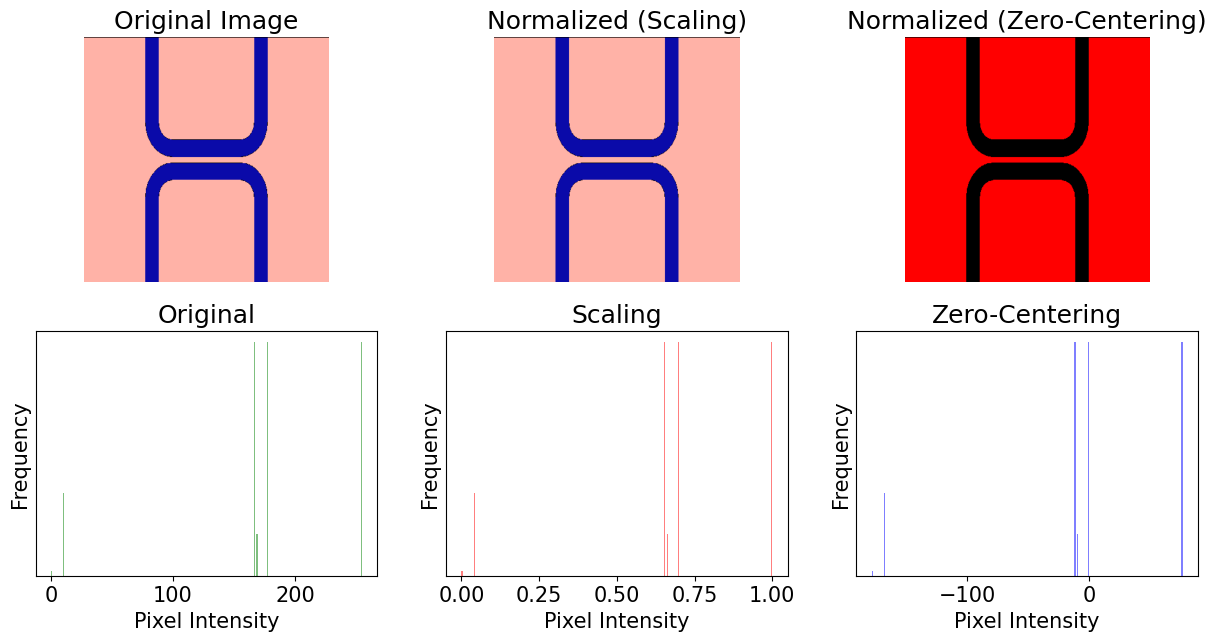

In [199]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array

# Load or create your image
img_path = '../output/3D_34.png'
img = image.load_img(img_path, target_size=(400, 400))  # Adjust target_size as needed

# Convert the image to a NumPy array
img_array = img_to_array(img)

# Type 1: Scaling to [0, 1]
normalized_image_1 = img_array / 255.0

# Type 2: Zero-centering
mean_intensity = np.mean(img_array)
normalized_image_2 = img_array - mean_intensity

# Plot the original and normalized images along with pixel intensity distribution
plt.figure(figsize=(15, 7))

# Original Image
plt.subplot(2, 3, 1)
plt.imshow(img_array.astype('uint8'))
plt.title('Original Image')
plt.axis('off')

# Pixel intensity distribution for Original Image
plt.subplot(2, 3, 4)
plt.hist(img_array.flatten(), bins=256, range=[0, 255], color='g', alpha=0.5)
plt.yticks([])
plt.title("Original")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")

# Normalized Image (Type 1)
plt.subplot(2, 3, 2)
plt.imshow(normalized_image_1)
plt.title('Normalized (Scaling)')
plt.axis('off')

# Pixel intensity distribution for Type 1
plt.subplot(2, 3, 5)
plt.hist(normalized_image_1.flatten(), bins=256, range=[0, 1], color='r', alpha=0.5)
plt.yticks([])
plt.title("Scaling")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")

# Normalized Image (Type 2)
plt.subplot(2, 3, 3)
plt.imshow(normalized_image_2)
plt.title('Normalized (Zero-Centering)')
plt.axis('off')

# Pixel intensity distribution for Type 2
plt.subplot(2, 3, 6)
plt.hist(normalized_image_2.flatten(), bins=256, color='b', alpha=0.5)
plt.title("Zero-Centering")
plt.yticks([])
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")

plt.show()

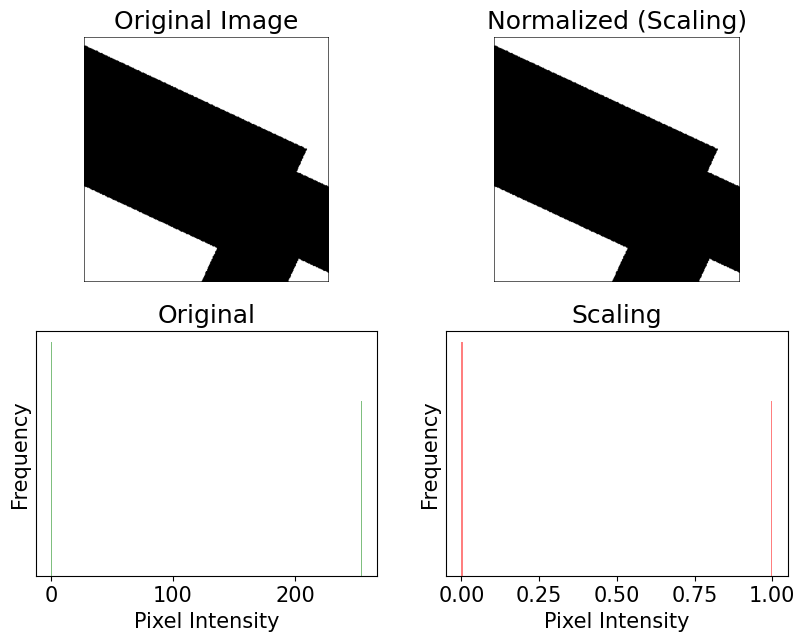

In [203]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array

# Load or create your image
img_path = '../output/tiles/branch_line_coupler_65_500_2_2.png'
img = image.load_img(img_path, target_size=(400, 400))  # Adjust target_size as needed

# Convert the image to a NumPy array
img_array = img_to_array(img)

# Type 1: Scaling to [0, 1]
normalized_image_1 = img_array / 255.0

# Type 2: Zero-centering
mean_intensity = np.mean(img_array)
normalized_image_2 = img_array - mean_intensity

# Function to add frame to an image
def add_frame(img, color='black', thickness=1):
    img_h, img_w, _ = img.shape
    framed_img = np.copy(img)
    framed_img[:thickness, :, :] = framed_img[-thickness:, :, :] = 0
    framed_img[:, :thickness, :] = framed_img[:, -thickness:, :] = 0
    return framed_img

# Plot the original and normalized images along with pixel intensity distribution
plt.figure(figsize=(15, 7))

# Original Image

plt.subplot(2, 3, 1)
framed_original = add_frame(img_array, color='black')
plt.imshow(framed_original.astype('uint8'))
plt.title('Original Image')
plt.axis('off')

# Pixel intensity distribution for Original Image
plt.subplot(2, 3, 4)
plt.hist(img_array.flatten(), bins=256, range=[0, 255], color='g', alpha=0.5)
plt.yticks([])
plt.title("Original")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")

# Normalized Image (Type 1)
plt.subplot(2, 3, 2)
framed_normalized_image_1 = add_frame(normalized_image_1, color='black')
plt.imshow(framed_normalized_image_1)
plt.title('Normalized (Scaling)')
plt.axis('off')

# Pixel intensity distribution for Type 1
plt.subplot(2, 3, 5)
plt.hist(normalized_image_1.flatten(), bins=256, range=[0, 1], color='r', alpha=0.5)
plt.yticks([])
plt.title("Scaling")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")

# # Normalized Image (Type 2)
# plt.subplot(2, 3, 3)
# framed_normalized_image_2 = add_frame(normalized_image_2, color='black')
# plt.imshow(framed_normalized_image_2)
# plt.title('Normalized (Zero-Centering)')
# plt.axis('off')

# # Pixel intensity distribution for Type 2
# plt.subplot(2, 3, 6)
# plt.hist(normalized_image_2.flatten(), bins=256, color='b', alpha=0.5)
# plt.title("Zero-Centering")
# plt.yticks([])
# plt.xlabel("Pixel Intensity")
# plt.ylabel("Frequency")

plt.show()

In [204]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

# Example feature data
feature_data = np.array([2.0, 5.0, 8.0, 11.0, 14.0])

# Min-Max Scaling
min_max_scaled = MinMaxScaler().fit_transform(feature_data.reshape(-1, 1)).flatten()

# Standardization
standardized = StandardScaler().fit_transform(feature_data.reshape(-1, 1)).flatten()

# Robust Scaling
robust_scaled = RobustScaler().fit_transform(feature_data.reshape(-1, 1)).flatten()

print("Original Feature Data:", feature_data)
print("Min-Max Scaled Data:", min_max_scaled)
print("Standardized Data:", standardized)
print("Robust Scaled Data:", robust_scaled)


Original Feature Data: [ 2.  5.  8. 11. 14.]
Min-Max Scaled Data: [0.   0.25 0.5  0.75 1.  ]
Standardized Data: [-1.41421356 -0.70710678  0.          0.70710678  1.41421356]
Robust Scaled Data: [-1.  -0.5  0.   0.5  1. ]
